## Libraries

In [ ]:
# Библиотеки PyTorch
import torch 
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn # готовые слои (как в Keras)
import torch.optim as optim

import os

import matplotlib.pyplot as plt
import PIL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_to_dataset = '/content/drive/MyDrive/Colab\ Notebooks/Machine_learning/Datasets/flowers.zip'

In [ ]:
!unzip -q {path_to_dataset}

In [ ]:
# Трансформации для объекта
transform = transforms.Compose([
                  transforms.Resize([32, 32]), # Приведение к размеру 32 на 32
                  transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Нормализация
                ])

In [ ]:
batch_size = 32

# Папка для DataLoader
train_set = torchvision.datasets.ImageFolder(root='flowers', transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
# num_workers = 1 - для исключения многопоточности GIL
# https://pytorch.org/docs/stable/data.html#single-and-multi-process-data-loading
# y-ответы OHE PyTorch готовит сам исходя из содержимого папки flowers

## NN

Нейронная сеть по аналогии с этой:   
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html 

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.l1 = nn.Linear(128*8*8, out_features=1024)
        self.l2 = nn.Linear(1024, out_features=100)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = torch.relu(self.l1(x))
        x = self.l2(x)
        return x

net = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
dirs = sorted(os.listdir('flowers'))
dirs

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

## Model training

In [ ]:
epochs = 20

for epoch in range(epochs):
    running_loss = 0.0

    print("Идёт Эпоха: ", epoch)
    for i, data in enumerate(trainLoader):
        inputs, labels = data
        optimizer.zero_grad() # Чтобы можно было пересчитывать веса
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

Идёт Эпоха:  0
Идёт Эпоха:  1
Идёт Эпоха:  2
Идёт Эпоха:  3
Идёт Эпоха:  4
Идёт Эпоха:  5
Идёт Эпоха:  6
Идёт Эпоха:  7
Идёт Эпоха:  8
Идёт Эпоха:  9
Идёт Эпоха:  10
Идёт Эпоха:  11
Идёт Эпоха:  12
Идёт Эпоха:  13
Идёт Эпоха:  14
Идёт Эпоха:  15
Идёт Эпоха:  16
Идёт Эпоха:  17
Идёт Эпоха:  18
Идёт Эпоха:  19


## Predict by NN

Скачивание картинок из интернета для проведения тестов   
Не забудь переименовать изображения!

In [ ]:
!wget -q 'https://w2w.com.ua/wp-content/uploads/2021/12/k-chemu-snitsja-pokupat-rozy-na-rynke-ili-v-magazine-50-tolkovanij-iz-raznyh-sonnikov-2902c21.jpg'

In [ ]:
!wget -q 'https://wallbox.ru/resize/640x480/wallpapers/main/201311/9857d8eb641146a.jpg'

In [ ]:
!wget -q 'https://i.ytimg.com/vi/Txg0K-9GJPQ/hqdefault.jpg'

In [ ]:
!wget -q 'https://www.overheaddoorpermianbasin.com/hs-fs/hubfs/daisy-821222_960_720.jpg?width=640&name=daisy-821222_960_720.jpg'

In [ ]:
!wget -q 'https://sun9-34.userapi.com/c12789/u5911662/video/l_e7ca918a.jpg'

Функция красивого вывода с GitHub-а

In [ ]:
def show(images, labels=None, figsize=None, colsrows=None):
    if labels: 
        if len(labels) != len(images): raise Exception('invalid length')

    figsize = figsize if figsize else (10, 10)
    figure = plt.figure(figsize=figsize)
    colsrows = colsrows if colsrows else (len(images), 1)
    cols, rows = colsrows[0], colsrows[1]

    for i in range(0, cols * rows):
        figure.add_subplot(rows, cols, i + 1)
        if labels: plt.title(labels[i])
        plt.axis("off")
        plt.imshow(images[i])

    plt.show()

In [ ]:
def predict(path_to_file):
    img = PIL.Image.open(path_to_file)
    tensor = transform(img) # Перевод изображения в tensor PyTorch

    prediction = net(tensor) # Использование функции предикта
    _, prediction = torch.max(prediction.data, 1) # Возращаются вероятности каждого исхода
    id = int(list(prediction)[0]) # Взятие id наилучшего результата

    label = dirs[id]
    return label

In [ ]:
predict('rose_test.jpg')

'rose'

In [ ]:
tests = ['/content/dandelion.jpg', '/content/daisy.jpg', '/content/rose_test.jpg', '/content/sunflower_test.jpg', '/content/tulip_test.jpg']
results = [predict(i) for i in tests]
results

['dandelion', 'daisy', 'rose', 'sunflower', 'tulip']

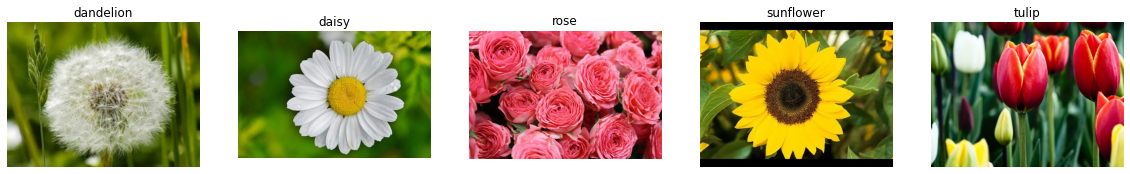

In [ ]:
images = [PIL.Image.open(i) for i in tests] # Перевод всех изображений в PIL-ов изображения
show(images, results, (20, 20), (5,1))

In [ ]:
# Как выгрузить модель?
# TorchServ-20230529T134133Z-001.zip
# 

model = resnet34(pretrained=True)
example_input = torch.rand(1, 3, 224, 224)

model.eval()
traced_model = torch.jit.trace(model, example_input)
traced_model.save("resnet34.pt")